### USAGE
- Define the path where CNN and MLP models are saved (2nd block of code, after `useful functions`)
- Define the `clustered` and `shuffled` model output
- Pick either `clustered` or `shuffled` model to explore in `model_name`
- Run all code blocks.

In [1]:
import torch
import sys
sys.path.append("../4_train_models/")
from CNN.SeqBased_models import MlpRegBaseline
from CNN.datasets import Class_Seq_Dataset
import matplotlib.pylab as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
import os
import pandas as pd

In [2]:
# useful functions:
def get_metrics(model_path, cluster=False):
    cp = torch.load(model_path, map_location=torch.device("cpu"))
    xval_data = cp["models_data"]
    a = cp["arguments"]
    cluster_column = (None, a.cluster_column)[a.cluster]
    # check if file generated locally or on snellius (csv path changes):
    if ("/home/lepikhovd/" in a.csv_file):
        csv_path = "../../data/external/processed/" + a.csv_file.split("/")[-1]
    else:
        csv_path = a.csv_file
    dataset = Class_Seq_Dataset(
        csv_path,
        a.encoder,
        "cpu",
        threshold=a.threshold,
        cluster_column = (None, a.cluster_column)[a.cluster]
    )

    train_tpr = []
    train_losses = []
    train_tnr = []
    train_accuracies = []

    valid_tpr = []
    valid_losses = []
    valid_tnr = []
    valid_accuracies = []

    test_tpr = []
    test_losses = []
    test_tnr = []
    test_accuracies = []

    best_model_test_tprs = []
    best_model_test_tnrs = []
    best_model_test_accuracies = []

    aucs = []
    mccs = []

    for data in xval_data:
        # load the model and data
        input_dimensions = dataset.input_size
        model = MlpRegBaseline(neurons_per_layer=a.neurons, input=input_dimensions, outputs=2) 
        model.load_state_dict(data["model"])
        model.eval()


        ### RETREIVE THE METRICS ###
        train_tpr.append(data["train_tpr"]);train_tnr.append(data["train_tnr"]);train_losses.append(data["train_losses"]);
        train_accuracies.append(data["train_accuracies"]);

        valid_tpr.append(data["validation_tpr"]);valid_tnr.append(data["validation_tnr"])
        valid_losses.append(data["validation_losses"]);valid_accuracies.append(data["validation_accuracies"]);

        test_tpr.append(data["test_tpr"]);test_tnr.append(data["test_tnr"]);test_losses.append(data["test_losses"]);
        test_accuracies.append(data["test_accuracies"]);

        ### MAKE THE PREDICTION ON THE TEST DATASET ###
        test_peptides = dataset.peptides[data["test_indices"]]
        test_targets = dataset.labels[data["test_indices"]]

        with torch.no_grad():
            logits = model(test_peptides)
            prob = logits.max(1)[0] 
            pred = logits.max(1)[1]

        confusion = pred/test_targets # absolute values for metrics
        tot = test_targets.shape[0] # total number of prediction
        pos = float((test_targets == 1.).sum()) # total number of positives (truth 1)
        neg = float((test_targets == 0.).sum()) # total number of negatives (truth 0)

        best_model_test_tprs.append(float((confusion == 1.).sum()/pos)) # true prositive rate = prediction 1/truth 1
        best_model_test_tnrs.append(float((torch.isnan(confusion)).sum()/neg)) # true prositive rate = prediction 1/truth 1
        best_model_test_accuracies.append(float((pred==test_targets).sum()/tot))

        tpr, fpr, _ = roc_curve(test_targets, prob) 
        aucs.append(auc(fpr, tpr))
        mccs.append(matthews_corrcoef(test_targets, pred))

    return \
        best_model_test_tprs, best_model_test_tnrs, \
        aucs, mccs, best_model_test_accuracies, \
        train_accuracies, valid_accuracies, test_accuracies,\
        train_tpr, valid_tpr, test_tpr,\
        train_tnr, valid_tnr, test_tnr,\
        train_losses, valid_losses, test_losses

def save_best_metrics(model_name, test_best_tpr, test_best_tnr, test_auc, test_mcc,
    test_best_accuracies
):
    d = {
        "sensitivity_mean": [float(test_best_tpr.mean())],
        "sensitivity_std": [float(test_best_tpr.std())],
        "specificity_mean": [float(test_best_tnr.mean())],
        "specificity_std": [float(test_best_tnr.std())],
        "auc_mean": [float(test_auc.mean())],
        "auc_std": [float(test_auc.std())],
        "mcc_mean": [float(test_mcc.mean())],
        "mcc_std": [float(test_mcc.std())],
        "accuracy_mean": [float(test_best_accuracies.mean())],
        "accuracy_std": [float(test_best_accuracies.std())],
        "model_path": [model_name],
    }
    df = pd.DataFrame(d)
    metrics_csv_path = "./best_models_metrics.csv"
    if os.path.exists(metrics_csv_path):
        csv_df = pd.read_csv(metrics_csv_path)
        concat_df = pd.concat([csv_df, df])
        concat_df.to_csv(metrics_csv_path, index=False)
    else:
        df.to_csv(metrics_csv_path, index=False)

In [3]:
# models_path = "/home/daqop/Desktop/M2/Internship/python/trained_models/" # path to where CNN and MLP models are stored
models_path = "/home/daqop/mountpoint_snellius/3D-Vac/src/4_train_models/CNN/I/classification/seq/trained_models/" 
# models_path = "/home/daqop/Desktop/3D-vac-project/trained_models/" 
model_names = {
    "shuffled": "mlp_classification_sparse_with_allele_encoder_100_neurons_25_epochs_100K_dataset_normal_label_32_batch_size.pt",
    "clustered": "mlp_classification_sparse_encoder_1000_neurons_50_epochs_test_32_batch_size.pt",
}
model_name = model_names["shuffled"]
best_model_test_tprs, best_model_test_tnrs, \
aucs, mccs, best_model_test_accuracies, \
train_accuracies, valid_accuracies, test_accuracies, \
train_tpr, valid_tpr, test_tpr, \
train_tnr, valid_tnr, test_tnr, \
train_losses, valid_losses, test_losses = get_metrics(models_path + model_name)

aucs = torch.tensor(aucs)
mccs = torch.tensor(mccs)

best_model_test_tprs = torch.tensor(best_model_test_tprs)
best_model_test_tnrs = torch.tensor(best_model_test_tnrs)
best_model_test_accuracies = torch.tensor(best_model_test_accuracies)

train_accuracies = torch.permute(torch.tensor(train_accuracies), (1,0))
valid_accuracies = torch.permute(torch.tensor(valid_accuracies), (1,0))
test_accuracies = torch.permute(torch.tensor(test_accuracies), (1,0))

train_tpr = torch.permute(torch.tensor(train_tpr), (1,0))
valid_tpr = torch.permute(torch.tensor(valid_tpr), (1,0))
test_tpr = torch.permute(torch.tensor(test_tpr), (1,0))

train_tnr = torch.permute(torch.tensor(train_tnr), (1,0))
valid_tnr = torch.permute(torch.tensor(valid_tnr), (1,0))
test_tnr = torch.permute(torch.tensor(test_tnr).nan_to_num(), (1,0))

train_losses = torch.permute(torch.tensor(train_losses), (1,0))
valid_losses = torch.permute(torch.tensor(valid_losses), (1,0))
test_losses = torch.permute(torch.tensor(test_losses), (1,0))

In [12]:
save_best_metrics(model_name, best_model_test_tprs, best_model_test_tprs,
    aucs, mccs, best_model_test_accuracies
)

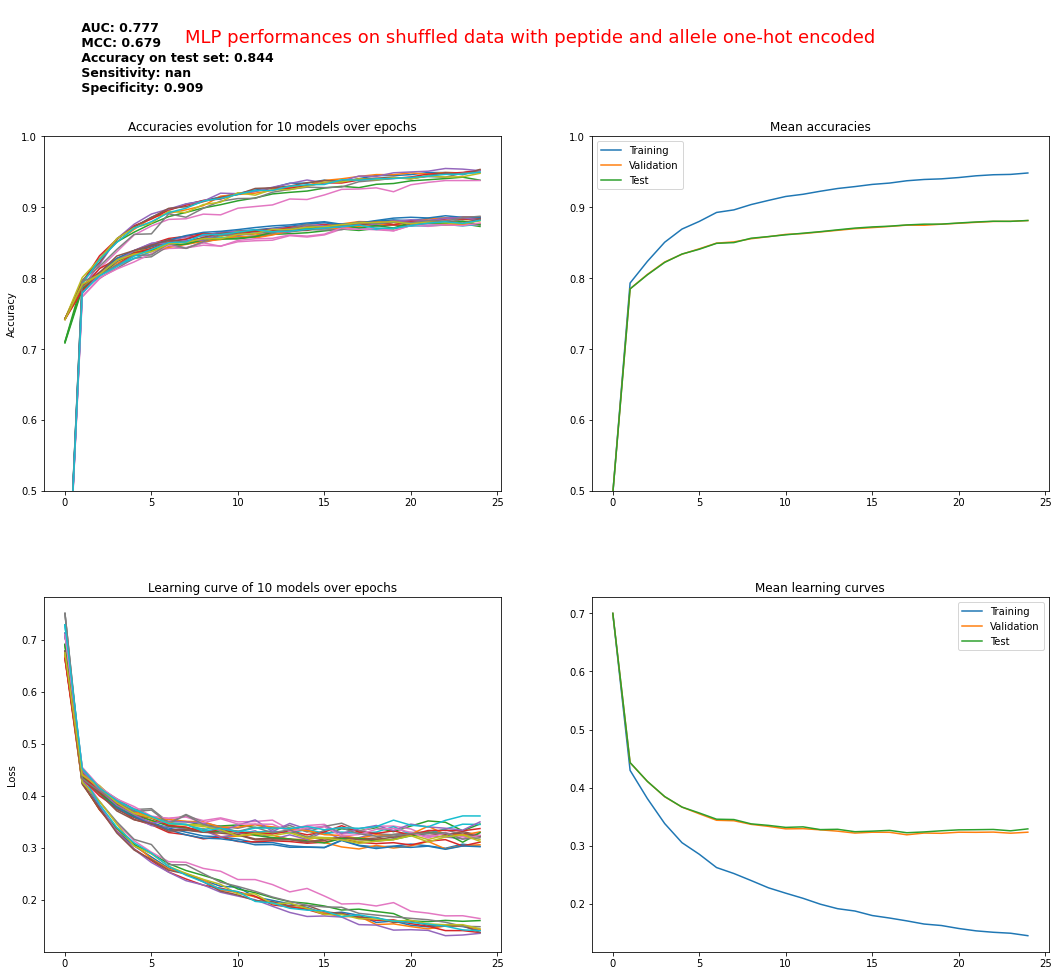

In [4]:
fig = plt.figure(figsize=(18,15))
((ax1, ax2), (ax3, ax4)) = fig.subplots(2, 2)
fig.suptitle(f"MLP performances on shuffled data with peptide and allele one-hot encoded", color="red", fontsize=18)
fig.text(
    0.15,1,
    f"\n AUC: {aucs.mean():.3} \n MCC: {mccs.mean():.3} \n \
Accuracy on test set: {test_accuracies.mean():.3} \n Sensitivity: {test_tpr.mean():.3} \n Specificity: {test_tnr.mean():.3}",
    horizontalalignment="left",
    verticalalignment="top",
    fontweight=700,
    fontsize=12.5
)

e = range(train_accuracies.shape[0])

ax1.plot(e, train_accuracies)
ax1.plot(e, valid_accuracies)
ax1.plot(e, test_accuracies)
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracies evolution for 10 models over epochs")
ax1.set_ylim(0.5,1)

ax2.plot(e, train_accuracies.mean(1))
ax2.plot(e, valid_accuracies.mean(1))
ax2.plot(e, test_accuracies.mean(1))
ax2.set_title("Mean accuracies")
ax2.legend(["Training", "Validation", "Test"])
ax2.set_ylim(0.5,1)

ax3.plot(e, train_losses)
ax3.plot(e, valid_losses)
ax3.plot(e, test_losses)
ax3.set_ylabel("Loss")
ax3.set_title("Learning curve of 10 models over epochs")

ax4.plot(e, train_losses.mean(1))
ax4.plot(e, valid_losses.mean(1))
ax4.plot(e, test_losses.mean(1))
ax4.set_title("Mean learning curves")
ax4.legend(["Training", "Validation", "Test"])

fig.subplots_adjust(
    wspace=.2,
    hspace=.3
)
fig.savefig(f"/home/daqop/mountpoint_snellius/3D-Vac/reports/figures/exp_results/{model_names['shuffled']}.svg", transparent=False, facecolor="white")